In [2]:
list_len = 15
num_lists = 1000

exp = 'CourierReinstate1'
subjects = ['LTP564', 'LTP565', 'LTP566', 'LTP567', 'LTP568', 'LTP569', 'LTP571', 'LTP572', 'LTP573',
            'LTP574', 'LTP575', 'LTP576', 'LTP577', 'LTP578', 'LTP579', 'LTP580', 'LTP581', 'LTP583',
            'LTP584', 'LTP585', 'LTP586', 'LTP587', 'LTP588', 'LTP589', 'LTP590', 'LTP591', 'LTP592', 
            'LTP593', 'LTP594', 'LTP595', 'LTP596', 'LTP597', 'LTP598', 'LTP599', 'LTP600', 'LTP601', 
            'LTP602', 'LTP603', 'LTP604', 'LTP605']

In [3]:
def save_data(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Dictionary saved to {filename}")

def load_data(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [4]:
df = cml.get_data_index('ltp', rootdir='/').query("experiment == @exp")

full_evs = None
for i, row in df.iterrows():
    reader = cml.CMLReader(subject=row['subject'], experiment=row['experiment'], session=row['session'])
    evs = reader.load('task_events')
    full_evs = evs if full_evs is None else pd.concat([full_evs, evs], ignore_index=True)
full_evs = full_evs.query("subject in @subjects")
full_evs = full_evs[(full_evs['item'] != "AMPLIFIER") & (full_evs['item'] != "APPLE") & (full_evs['item'] != "AXE") & 
                    (full_evs['item'] != "BASKETBALL_HOOP") & (full_evs['item'] != "DOOR") & (full_evs['item'] != "IRONING_BOARD") & 
                    (full_evs['item'] != "SHOVEL") & (full_evs['item'] != "STOVE")]

In [5]:
with open("words.pkl", "rb") as f:
    wordpool = pickle.load(f)

In [6]:
def compute_recall_rate(data):
    word_evs = data[data['type'] == 'WORD']
    return word_evs['recalled'].sum() / len(word_evs)

def compute_first_recall(data, list_len):
    rec_evs = data[data['type'] == 'REC_WORD']
    rec_evs['pos'] = rec_evs.groupby(['session', 'trial']).cumcount()
    first_recall_df = rec_evs.query('pos == 0 and serialpos >= 0')
    first_recall_df = first_recall_df.groupby(
        ['serialpos']).agg(
        {'recalled': 'count'}).reindex(range(1, list_len+1), fill_value=0)
    n_lists = first_recall_df['recalled'].sum()
    return first_recall_df['recalled'].to_numpy(dtype=float) / n_lists

def compute_lag_crp_single_subject_array(
    data, 
    list_len
):
    center = list_len - 1
    min_lag = -center
    max_lag = center + 1
    actual = {lag: 0 for lag in range(min_lag, max_lag)}
    possible = {lag: 0 for lag in range(min_lag, max_lag)}
    for session_id, session_data in data.groupby('session'):
        recalls = session_data[session_data.type == 'REC_WORD']
        # print(recalls)
        words = session_data[session_data.type == 'WORD']
        if recalls.empty or words.empty:
            print(f"session {session_id} has no events")
            continue
        # print(recalls.intruded)
        recalls = recalls[(recalls['trial'] != -999)]
        word_to_pos = dict(zip(words['item'], words['serialpos']))
        # print(word_to_pos)
        # print(recalls)
        for trial in recalls['trial'].unique():
            trial_words = words[words['trial'] == trial]['item'].tolist()
            trial_recalls = (recalls[recalls['trial'] == trial]
                             .sort_values('rectime')
                             .drop_duplicates('item'))
            
            if len(trial_recalls) < 2:
                print(f"session {session_id}, trial {trial} doesn't have enough events")
                continue
            trial_recalls = trial_recalls[trial_recalls['item'].isin(trial_words)]
            recall_pos = [word_to_pos[w] for w in trial_recalls['item']]
            # print(recall_pos)
            for i, cur in enumerate(recall_pos[:-1]):
                lag = recall_pos[i+1] - cur
                if min_lag <= lag <= max_lag and lag != 0:
                    actual[lag] += 1
                for pos in set(range(1, list_len+1)) - set(recall_pos[:i+1]):
                    pl = pos - cur
                    if min_lag <= pl <= max_lag and pl != 0:
                        possible[pl] += 1

    # build CRP array
    full_len = 2*list_len - 1
    crp = np.full(full_len, np.nan)
    center = list_len - 1
    for lag in range(min_lag, max_lag):
        idx = center + lag
        if 0 <= idx < full_len:
            crp[idx] = (actual[lag] / possible[lag]) if possible[lag] > 0 else np.nan
    crp[center] = 0.0
    return crp

In [7]:
df595 = full_evs[full_evs['subject'] == 'LTP595']
# compute_recall_rate(df595)
# compute_first_recall(df595, list_len)
crp595 = compute_lag_crp_single_subject_array(df595, list_len)
crp595

array([0.06382979, 0.05882353, 0.04424779, 0.02898551, 0.06470588,
       0.04102564, 0.05479452, 0.04979253, 0.07806691, 0.04895105,
       0.06644518, 0.08196721, 0.14195584, 0.3250774 , 0.        ,
       0.45721271, 0.20478723, 0.10670732, 0.06713781, 0.06477733,
       0.06161137, 0.0483871 , 0.03870968, 0.02459016, 0.04081633,
       0.05263158, 0.04081633, 0.        , 0.        ])

In [8]:
# CourierReinstate1 data
sub_parameters = {}

for sub in subjects:
    df_sub = full_evs[full_evs['subject'] == sub]
    recall_rate = compute_recall_rate(df_sub)
    first_recall = compute_first_recall(df_sub, list_len)
    lag_crp = compute_lag_crp_single_subject_array(df_sub, list_len)
    sub_parameters[sub] = {
        'recall_rate': recall_rate,
        'first_recall': first_recall,
        'lag_crp': lag_crp
    }

session 2, trial 7 doesn't have enough events


In [9]:
import optuna
import numpy as np

def crp_loss(simulated_crp, target_crp):
    mask = ~np.isnan(simulated_crp) & ~np.isnan(target_crp)
    return np.mean((simulated_crp[mask] - target_crp[mask])**2)

def make_objective(sub_id, sub_parameters, target_crp, list_len, num_lists, wordpool, n_avg=3):
    
    def objective(trial):
        # Suggest lag_crp distribution for this subject
        lag_crp = np.array([
            trial.suggest_float(f"lag_{i}", 1e-6, 1.0)
            for i in range(len(target_crp))
        ])
        lag_crp /= lag_crp.sum()  # normalize
        # print(lag_crp)
        # Pull subject parameters
        recall_rate = sub_parameters[sub_id]['recall_rate']
        first_recall = sub_parameters[sub_id]['first_recall']

        losses = []
        for _ in range(n_avg):
            sim = SimulatedSubjectData(
                subject=sub_id,
                first_recall=first_recall,
                lag_crp=lag_crp,
                recall_rate=recall_rate,
                value_acc=0.6,     # if you use this, add to sub_parameters
                complex_params=None,     # same here
                seed=None
            )
            df = sim.generateData(list_len, num_lists, num_lists_per_sess=10, wordpool=wordpool, gen_pos=True)
            sim_crp = compute_lag_crp_single_subject_array(df, list_len)
            losses.append(crp_loss(sim_crp, target_crp))

        return np.mean(losses)
    return objective


In [10]:
def early_stop_callback(study, trial):
    # stop if best loss hasn't improved in the last N trials
    if len(study.trials) > 10:  # require minimum trials first
        recent_losses = [t.value for t in study.trials[-10:] if t.value is not None]
        if max(recent_losses) - min(recent_losses) < 1e-4:  # threshold
            print("Convergence reached, stopping early")
            study.stop()

In [11]:
# # Example: pick a subject
# sub_id = subjects[0]
# target_crp = sub_parameters[sub_id]['lag_crp']  # empirical CRP

# # Create Optuna study
# study = optuna.create_study(direction="minimize")
# objective = make_objective(sub_id, sub_parameters, target_crp, list_len=15, num_lists=30, wordpool=wordpool, n_avg=5)
# study.optimize(objective, n_trials=100, callbacks=[early_stop_callback])

# print("Best loss:", study.best_value)

# best_lag_crp = np.array([study.best_params[f"lag_{i}"] for i in range(len(target_crp))])
# best_lag_crp /= best_lag_crp.sum()
# print("Best lag_crp distribution:", best_lag_crp)


In [12]:
# Configure logging at the top of your notebook/script
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s'
)
logger = logging.getLogger(__name__)

# set up slurm 
logdir = os.path.join(os.path.abspath(os.curdir), 'dask_appendix_logs')
# first_run = False
dask_args = {'job_name': "zrentala_workshop4", 'memory_per_job': "10GB", 'max_n_jobs': 20,
             'log_directory': './results/Assignment_8/cluster_logs'}
os.makedirs(dask_args['log_directory'], exist_ok=True)
client = da.new_dask_client(**dask_args)

Unique port for zrentala is 51618
{'dashboard_address': ':51618'}
To view the dashboard, run: 
`ssh -fN zrentala@rhino2.psych.upenn.edu -L 8000:192.168.86.101:51618` in your local computer's terminal (NOT rhino) 
and then navigate to localhost:8000 in your browser


In [13]:
def optimize_subject(folder, subject, sub_parameters, obj_params, wordpool):
    logger.info(f"Processing {subject}")
    list_len = obj_params['list_len']
    num_lists = obj_params['num_lists']
    n_avg = obj_params['n_avg']

    target_crp = sub_parameters[subject]['lag_crp']
    study = optuna.create_study(direction="minimize")
    objective = make_objective(subject, sub_parameters, target_crp, list_len=list_len, num_lists=num_lists, wordpool=wordpool, n_avg=n_avg)
    study.optimize(objective, n_trials=100, callbacks=[early_stop_callback])

    best_lag_crp = np.array([study.best_params[f"lag_{i}"] for i in range(len(target_crp))])
    best_lag_crp /= best_lag_crp.sum()

    results[subject] = {
        "best_loss": study.best_value,
        "best_lag_crp": best_lag_crp
    }
    
    save_data(results, f'{folder}/{subject}_optimized.pkl')
    
    return results

In [31]:
results = {}
folder = 'Optimization_Results'
subj_list = subjects
sub_params = sub_parameters
obj_params ={'list_len': 15, 'num_lists': 100, 'n_avg':5}

if not os.path.exists(folder):
    os.makedirs(folder)

delayed_results = [delayed(optimize_subject)(folder, subj, sub_params, obj_params,wordpool) for subj in subj_list]
results = compute(*delayed_results)

2025-09-29 14:06:10,669 [ERROR] Task exception was never retrieved
future: <Task finished name='Task-196873' coro=<Client._gather.<locals>.wait() done, defined at /usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
2025-09-29 14:06:10,706 [ERROR] Task exception was never retrieved
future: <Task finished name='Task-196872' coro=<Client._gather.<locals>.wait() done, defined at /usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
d

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_142746/3502462630.py", line 11, in <module>
    results = compute(*delayed_results)
              ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/dask/base.py", line 666, in compute
    results = schedule(dsk, keys, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/distributed/client.py", line 3278, in get
    results = self.gather(packed, asynchronous=asynchronous, direct=direct)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/distributed/client.p

In [37]:
def load_all_subjects_optimized(folder):
    """
    Loads all {subject}_optimized.pkl files in the folder and combines them into a single dictionary.
    """
    all_data = {}
    # find all files ending with _optimized.pkl
    files = glob.glob(os.path.join(folder, "*_optimized.pkl"))
    
    for file in files:
        with open(file, 'rb') as f:
            subject_data = pickle.load(f)  # this is a single dict like {'LTP564': {...}}
            # merge into all_data
            all_data.update(subject_data)
    
    return all_data


In [38]:
subj_optimized= load_all_subjects_optimized(folder)

In [39]:
subj_optimized

{'LTP564': {'best_loss': 0.0055493414612228075,
  'best_lag_crp': array([0.0110119 , 0.02733581, 0.00617177, 0.0160758 , 0.05401504,
         0.04701239, 0.04521675, 0.02308323, 0.07660252, 0.04021801,
         0.00210946, 0.01800742, 0.05911013, 0.0158429 , 0.0450173 ,
         0.00017494, 0.03703505, 0.01619944, 0.03893661, 0.05479134,
         0.0572741 , 0.00571436, 0.02352276, 0.04465391, 0.07115206,
         0.05101491, 0.00860917, 0.06229606, 0.04179483])},
 'LTP565': {'best_loss': 0.00845216751681757,
  'best_lag_crp': array([2.99320747e-02, 4.66189224e-02, 5.57610442e-02, 4.06332321e-02,
         2.91300540e-02, 1.13558021e-03, 5.60643761e-02, 3.93316502e-02,
         8.13195955e-05, 3.55010569e-02, 4.84742548e-02, 4.57877351e-02,
         2.61543809e-02, 2.68803325e-02, 3.54309628e-02, 4.48695383e-02,
         4.14300040e-02, 7.85093181e-03, 3.35575214e-02, 2.51866223e-03,
         2.94467790e-02, 4.35906839e-02, 4.35315421e-02, 5.30723100e-02,
         5.08780632e-02, 5.6340

In [40]:
# Simulated data

sim_dfs = {}

for sub, parameters in sub_parameters.items():
    best_lag_crp = subj_optimized[sub]['best_lag_crp']
    sim = SimulatedSubjectData(
        subject=sub,
        first_recall=parameters['first_recall'],
        lag_crp=best_lag_crp,
        recall_rate=parameters['recall_rate'],
        value_acc=0.6
    )
    df_sim = sim.generateData(list_len, num_lists, gen_pos=True)
    sim_dfs[sub] = df_sim

In [41]:
sim_crps = {}

for sub, df_sim in sim_dfs.items():
    sim_crps[sub] = compute_lag_crp_single_subject_array(df_sub, list_len)

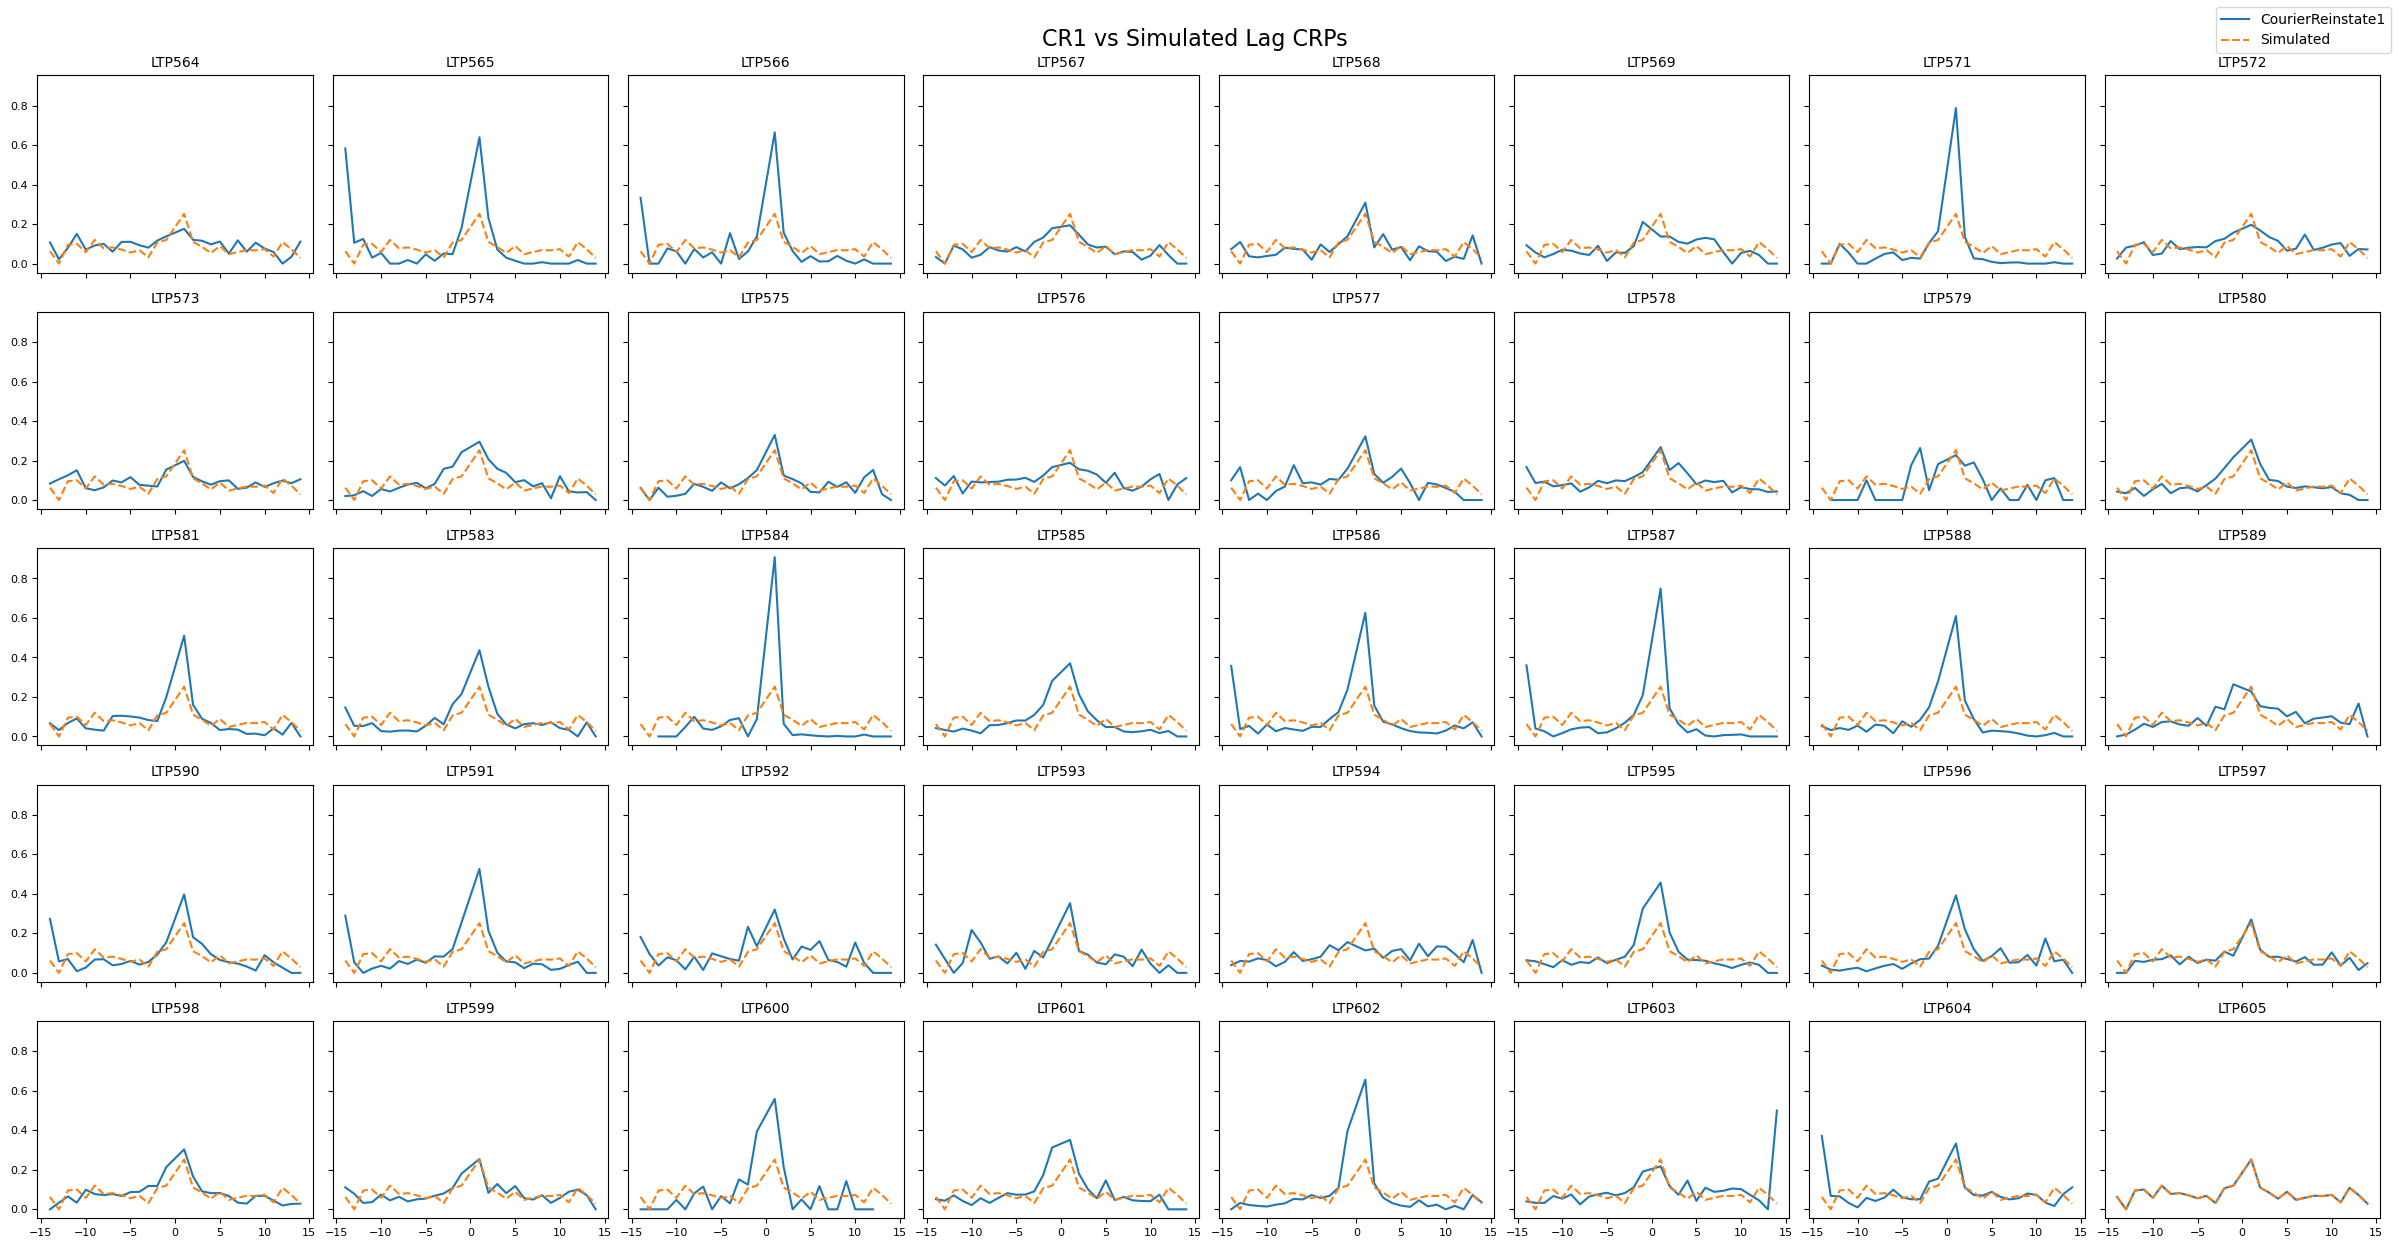

In [42]:
fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(24, 12.5), sharex=True, sharey=True)
axes = axes.flatten()

lags = np.arange(-(list_len-1), list_len)
mask = lags != 0
lags = lags[mask]

for ax, sub in zip(axes, sub_parameters.keys()):
    cr1_sub_crp = sub_parameters[sub]['lag_crp'][mask]
    sim_sub_crp = sim_crps.get(sub)
    if sim_sub_crp is not None:
        sim_sub_crp = sim_sub_crp[mask]
        ax.plot(lags, cr1_sub_crp, label="CourierReinstate1")
        ax.plot(lags, sim_sub_crp, linestyle="--", label="Simulated")
    ax.set_title(str(sub), fontsize=10)
    ax.tick_params(labelsize=8)

fig.suptitle("CR1 vs Simulated Lag CRPs", fontsize=16)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
plt.tight_layout()
plt.show()

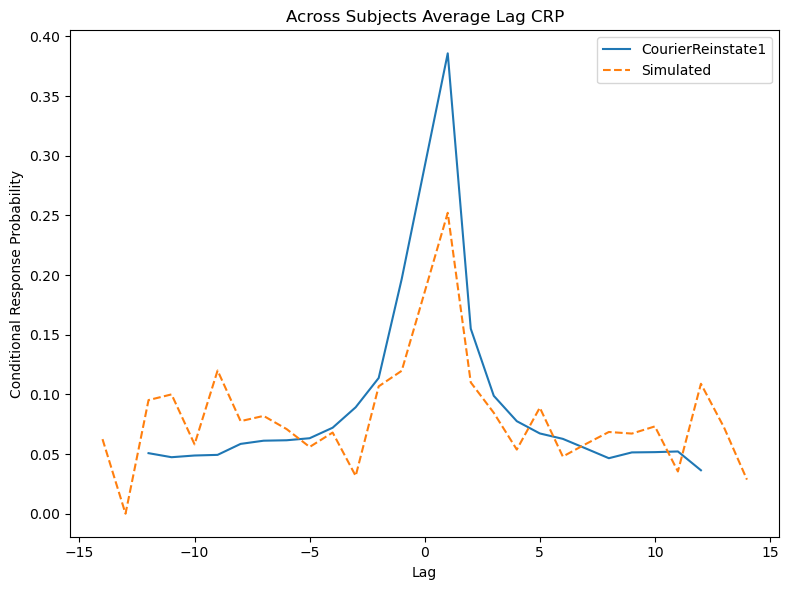

In [43]:
cr1_all_crp = None
sim_all_crp = None
cr1_stack = np.vstack([sub_parameters[sub]['lag_crp'] for sub in sub_parameters])
sim_stack = np.vstack([sim_crps.get(sub) for sub in sub_parameters if sub in sim_crps])
cr1_all_crp = cr1_stack.mean(axis=0)
sim_all_crp = sim_stack.mean(axis=0)

lags = np.arange(-(list_len-1), list_len)
mask = lags != 0
lags = lags[mask]

plt.figure(figsize=(8, 6))
plt.plot(lags, cr1_all_crp[mask], label="CourierReinstate1")
plt.plot(lags, sim_all_crp[mask], linestyle="--", label="Simulated")
plt.xlabel('Lag')
plt.ylabel('Conditional Response Probability')
plt.title('Across Subjects Average Lag CRP')
plt.legend()
plt.tight_layout()
plt.show()

In [44]:
errors = {}
lags = np.arange(-(list_len-1), list_len)
mask = lags != 0
lags = lags[mask]
        
for sub in sub_parameters.keys():
    if sub in sim_crps:
        cr1_sub_crp = sub_parameters[sub]['lag_crp'][mask]
        sim_sub_crp = sim_crps.get(sub)
        if sim_sub_crp is not None:
            sim_sub_crp = sim_sub_crp[mask]
        errors[sub] = np.sqrt(((cr1_sub_crp - sim_sub_crp) ** 2).mean())
    
errors

{'LTP564': 0.042351524579098666,
 'LTP565': 0.1381410277832822,
 'LTP566': 0.10705037452644105,
 'LTP567': 0.03889239445058104,
 'LTP568': 0.044935339489935666,
 'LTP569': 0.05095420020918164,
 'LTP571': 0.11450333663635567,
 'LTP572': 0.045515272869582214,
 'LTP573': 0.039719352299512276,
 'LTP574': 0.05733270158406528,
 'LTP575': 0.040686365789997375,
 'LTP576': 0.0535484728893016,
 'LTP577': 0.061885499469400355,
 'LTP578': 0.045818840562324256,
 'LTP579': nan,
 'LTP580': 0.044497027325257586,
 'LTP581': 0.06551322505603774,
 'LTP583': 0.06429969207541998,
 'LTP584': nan,
 'LTP585': 0.06178858274509149,
 'LTP586': 0.1012976139851743,
 'LTP587': 0.12217249192356645,
 'LTP588': 0.08844805271969004,
 'LTP589': 0.054934620287576175,
 'LTP590': 0.06427860329849082,
 'LTP591': 0.08574928138108186,
 'LTP592': 0.06431773655099045,
 'LTP593': 0.05850226225775906,
 'LTP594': 0.0550813530829432,
 'LTP595': 0.06872409241025312,
 'LTP596': 0.06044503304244478,
 'LTP597': 0.028491435889745093,
 '

In [45]:
avg_error = np.nanmean(list(errors.values()))
avg_error

0.06442878097962294